# Stochastic Gradient Descent 
Deep Learning - KI29  
Deggendorf Institute of Technology  
Prof. Dr. Florian Wahl

## Existierende Codebase

In [1]:
import nnfs
from nnfs.datasets import spiral_data

In [2]:
import numpy as np

In [3]:
# Dense Layer
class Layer_Dense:
    
    # Initialization Code
    def __init__(self, n_inputs, n_neurons):
        # Initilalize weights and biases according to the shape given
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))
    
    def forward(self, inputs):
        self.inputs = inputs
        
        # Calculate output as we did on the slides
        self.output = np.dot(inputs, self.weights) + self.biases
        
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        
        # Gradients on values
        self.dinputs = np.dot(dvalues, self.weights.T)

In [4]:
class Activation_ReLU:
    
    def forward(self, inputs):
        self.inputs = inputs
        
        # Calculate the output based on inputs. 
        self.output = np.maximum(0, inputs)
        
    def backward(self, dvalues):
        # Copy before we modify
        self.dinputs = dvalues.copy()
        
        # Set to 0 if value is <=0
        self.dinputs[self.inputs <= 0] = 0

In [5]:
class Loss:
    def calculate(self, output, y):
        # Calculate the per sample loss
        samples_losses = self.forward(output, y)

        # Calculate the mean loss and return it
        loss = np.mean(samples_losses)
        return loss

In [6]:
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        n_samples = len(y_pred)  # Count the samples

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)  # Clip the predictions

        # Get correct confidence values
        # if labels are sparse
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(n_samples), y_true]

        # else if labels are one hot encoded
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        # Compute Losses
        losses = -np.log(correct_confidences)
        return losses
    
    # Backward pass
    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])
        
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        
        # Calculate gradient
        self.dinputs = -y_true / dvalues
        
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [7]:
# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True)) 
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True) 
        
        # Normalize them for each sample
        self.output = probabilities
    
    def backward(self, dvalues):
        # Create uninitialized array
        self.dinputs = np.empty_like(dvalues)

        # Enumerate outputs and gradients
        for index, (single_output, single_dvalues) in \
        enumerate(zip(self.output, dvalues)):
            # Flatten output array
            single_output = single_output.reshape(-1, 1)
            
            # Calculate Jacobian matrix of the output
            jacobian_matrix = np.diagflat(single_output) - \
                              np.dot(single_output, single_output.T)
            
            # Calculate sample-wise gradient
            # and add it to the array of sample gradients
            self.dinputs[index] = np.dot(jacobian_matrix, single_dvalues)

In [8]:
# Softmax classifier - combined Softmax activation
# and cross-entropy loss for faster backward step
class Activation_Softmax_Loss_CategoricalCrossentropy():
    # Creates activation and loss function objects
    def __init__(self):
        self.activation = Activation_Softmax() 
        self.loss = Loss_CategoricalCrossentropy()
    
    def forward(self, inputs, y_true):
        # Output layer's activation function 
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true): # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded, # turn them into discrete values 
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify 
        self.dinputs = dvalues.copy()
        # Calculate gradient 
        self.dinputs[range(samples), y_true] -= 1 
        # Normalize gradient
        self.dinputs = self.dinputs / samples

## Stochastic Gradient Descent Optmizer

In [9]:
# SGD optimizer
class Optimizer_SGD:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
        
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

## "Manuelles" Beispiel

In [12]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()

In [19]:

# Perform a forward pass of our training data through this layer
dense1.forward(X)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y)
# Let's print loss value
print('loss:', loss)
# Calculate accuracy from output of activation2 and targets # calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1) 
accuracy = np.mean(predictions==y)
print('acc:', accuracy)

loss: 1.0985807037370754
acc: 0.42


In [17]:
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

In [18]:
optimizer = Optimizer_SGD()

optimizer.update_params(dense1)
optimizer.update_params(dense2)

## Training in Epochen

In [28]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer
optimizer = Optimizer_SGD(learning_rate=1)

losses = []
accuracies = []

# Train in loop
for epoch in range(25001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    losses.append(loss)
    
    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions==y)
    accuracies.append(accuracy)
    if not epoch % 1000: 
        print(f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' + f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)

epoch: 0, acc: 0.367, loss: 1.099
epoch: 1000, acc: 0.437, loss: 1.042
epoch: 2000, acc: 0.580, loss: 0.894
epoch: 3000, acc: 0.647, loss: 0.732
epoch: 4000, acc: 0.690, loss: 0.620
epoch: 5000, acc: 0.770, loss: 0.531
epoch: 6000, acc: 0.800, loss: 0.446
epoch: 7000, acc: 0.813, loss: 0.409
epoch: 8000, acc: 0.820, loss: 0.390
epoch: 9000, acc: 0.843, loss: 0.374
epoch: 10000, acc: 0.863, loss: 0.397
epoch: 11000, acc: 0.880, loss: 0.361
epoch: 12000, acc: 0.880, loss: 0.316
epoch: 13000, acc: 0.893, loss: 0.331
epoch: 14000, acc: 0.890, loss: 0.351
epoch: 15000, acc: 0.903, loss: 0.320
epoch: 16000, acc: 0.907, loss: 0.303
epoch: 17000, acc: 0.907, loss: 0.287
epoch: 18000, acc: 0.887, loss: 0.258
epoch: 19000, acc: 0.907, loss: 0.269
epoch: 20000, acc: 0.910, loss: 0.226
epoch: 21000, acc: 0.897, loss: 0.256
epoch: 22000, acc: 0.903, loss: 0.247
epoch: 23000, acc: 0.930, loss: 0.231
epoch: 24000, acc: 0.900, loss: 0.231
epoch: 25000, acc: 0.927, loss: 0.198


In [29]:
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
df = pd.DataFrame([losses, accuracies]).T
df = df.rename({0:"loss", 1:"accuracy"}, axis="columns")

array([<Axes: >, <Axes: >], dtype=object)

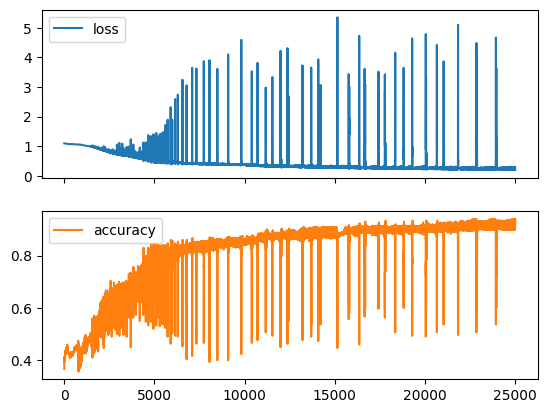

In [31]:
df.plot(subplots=True, sharex=True, sharey=False)

## Learning rate decay

In [35]:
tau_i = 1.0
decay = 0.5
step = 10

tau = tau_i * 1. / (1+decay*step)

print(f"Step {step}, new tau {round(tau, 3)}")

Step 10, new tau 0.167


In [36]:
# SGD optimizer
class Optimizer_SGD:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0, decay=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        
    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        layer.weights += -self.current_learning_rate * layer.dweights
        layer.biases += -self.current_learning_rate * layer.dbiases
        
    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [37]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer
optimizer = Optimizer_SGD(decay=1e-3)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(20001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions==y)
    if not epoch % 500: 
        print(f'lr: {round(optimizer.current_learning_rate, 3)}, ' + 
              f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

lr: 1.0, epoch: 0, acc: 0.307, loss: 1.099
lr: 0.667, epoch: 500, acc: 0.430, loss: 1.065
lr: 0.5, epoch: 1000, acc: 0.430, loss: 1.058
lr: 0.4, epoch: 1500, acc: 0.440, loss: 1.039
lr: 0.333, epoch: 2000, acc: 0.473, loss: 1.004
lr: 0.286, epoch: 2500, acc: 0.483, loss: 0.968
lr: 0.25, epoch: 3000, acc: 0.500, loss: 0.943
lr: 0.222, epoch: 3500, acc: 0.533, loss: 0.915
lr: 0.2, epoch: 4000, acc: 0.543, loss: 0.888
lr: 0.182, epoch: 4500, acc: 0.543, loss: 0.861
lr: 0.167, epoch: 5000, acc: 0.573, loss: 0.832
lr: 0.154, epoch: 5500, acc: 0.600, loss: 0.810
lr: 0.143, epoch: 6000, acc: 0.617, loss: 0.790
lr: 0.133, epoch: 6500, acc: 0.620, loss: 0.772
lr: 0.125, epoch: 7000, acc: 0.627, loss: 0.750
lr: 0.118, epoch: 7500, acc: 0.630, loss: 0.733
lr: 0.111, epoch: 8000, acc: 0.647, loss: 0.717
lr: 0.105, epoch: 8500, acc: 0.660, loss: 0.700
lr: 0.1, epoch: 9000, acc: 0.680, loss: 0.686
lr: 0.095, epoch: 9500, acc: 0.700, loss: 0.667
lr: 0.091, epoch: 10000, acc: 0.683, loss: 0.650
lr: 0.

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

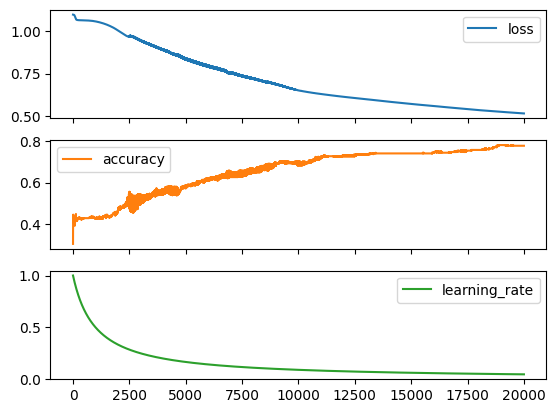

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0:"loss", 1:"accuracy", 2:"learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)

## Momentum

In [40]:
# SGD optimizer
class Optimizer_SGD:
# Initialize optimizer - set settings,
# learning rate of 1. is default for this optimizer 
    def __init__(self, learning_rate=1.0, decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
        
    # Call before running optimization
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))
        
    # Update parameters
    def update_params(self, layer):
        if self.momentum:
            # If layer has no momentum arrays, create them
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
                
            # Compute weight updates
            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates
            
            # Compute bias updates
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases
            layer.bias_momentums = bias_updates
        
        else:
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases
            
        # Perform update
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    # Call after running optimization
    def post_update_params(self):
        self.iterations += 1

In [41]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 64 output values
dense1 = Layer_Dense(2, 64)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 64 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(64, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Create optimizer

optimizer = Optimizer_SGD(decay=1e-3, momentum=0.9)

losses = []
accuracies = []
learning_rates = []

# Train in loop
for epoch in range(10001):
    # Perform a forward pass of our training data through this layer
    dense1.forward(X)
    # Perform a forward pass through activation function
    # takes the output of first dense layer here
    activation1.forward(dense1.output)
    # Perform a forward pass through second Dense layer
    # takes outputs of activation function of first layer as inputs
    dense2.forward(activation1.output)
    # Perform a forward pass through the activation/loss function
    # takes the output of second dense layer here and returns loss
    loss = loss_activation.forward(dense2.output, y)
    
    # Calculate accuracy from output of activation2 and targets # calculate values along first axis
    predictions = np.argmax(loss_activation.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1) 
    accuracy = np.mean(predictions==y)
    if not epoch % 1000: 
        print(f'lr: {round(optimizer.current_learning_rate, 3)}, ' + 
              f'epoch: {epoch}, ' +
              f'acc: {accuracy:.3f}, ' + 
              f'loss: {loss:.3f}')
    # Backward pass
    loss_activation.backward(loss_activation.output, y)
    dense2.backward(loss_activation.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)
    # Update weights and biases
    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()
    
    losses.append(loss)
    accuracies.append(accuracy)
    learning_rates.append(optimizer.current_learning_rate)

lr: 1.0, epoch: 0, acc: 0.373, loss: 1.099
lr: 0.5, epoch: 1000, acc: 0.827, loss: 0.401
lr: 0.333, epoch: 2000, acc: 0.843, loss: 0.358
lr: 0.25, epoch: 3000, acc: 0.907, loss: 0.287
lr: 0.2, epoch: 4000, acc: 0.907, loss: 0.270
lr: 0.167, epoch: 5000, acc: 0.907, loss: 0.258
lr: 0.143, epoch: 6000, acc: 0.903, loss: 0.252
lr: 0.125, epoch: 7000, acc: 0.900, loss: 0.249
lr: 0.111, epoch: 8000, acc: 0.903, loss: 0.246
lr: 0.1, epoch: 9000, acc: 0.903, loss: 0.242
lr: 0.091, epoch: 10000, acc: 0.903, loss: 0.240


array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

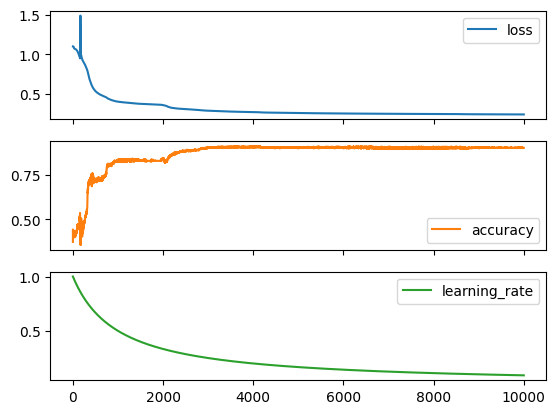

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.DataFrame([losses, accuracies, learning_rates]).T
df = df.rename({0:"loss", 1:"accuracy", 2:"learning_rate"}, axis="columns")
df.plot(subplots=True, sharex=True, sharey=False)